# Маркетинговый анализ

Исходные данные:
* Один источник трафика - крупная видеосеть.
* Период один месяц. 01.09-30.09.
* Таблица с установками по источнику
* Таблица с платежами по источнику

Задание:
* Определить окупилась ли кампания.
* Каких сабпаблишеров* стоит отключить, а на каких поднять ставку? (Сабпаблишером является уникальный “Site ID” в рамках уникального “Campaign”.)
* Проверить гипотезы: iPhone платит лучше iPad; iPhone X самый платящий девайс.

## EDA

Первый шаг в любом анализе — разведка. Взглянем на основные признаки и попробуем понять структуру данных.

Для этого вначале импортируем необходимые библиотеки и загрузим данные. Я буду использовать Python и его пакеты.

In [541]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

pd.options.display.max_columns = 100

date_cols = ["Attributed Touch Time", "Install Time", "Event Time"]
installs = pd.read_csv("data/installs.csv",
                       sep="\t", parse_dates=date_cols)
payments = pd.read_csv("data/payments.csv",
                       sep="\t", parse_dates=date_cols)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (36,42,43,44,45,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [542]:
installs.head()

,Attributed Touch Type,Attributed Touch Time,Install Time,Event Time,Event Name,Event Value,Event Revenue,Event Revenue Currency,Event Revenue USD,Event Source,Is Receipt Validated,Partner,Channel,Keywords,Campaign,Campaign ID,Adset,Adset ID,Ad,Ad ID,Ad Type,Site ID,Sub Site ID,Sub Param 1,Sub Param 2,Sub Param 3,Sub Param 4,Sub Param 5,Cost Model,Cost Value,Cost Currency,Contributor 1 Partner,Contributor 1 Media Source,Contributor 1 Campaign,Contributor 1 Touch Type,Contributor 1 Touch Time,Contributor 2 Partner,Contributor 2 Media Source,Contributor 2 Campaign,Contributor 2 Touch Type,Contributor 2 Touch Time,Contributor 3 Partner,Contributor 3 Media Source,Contributor 3 Campaign,Contributor 3 Touch Type,Contributor 3 Touch Time,Region,Country Code,State,City,Postal Code,DMA,IP,WIFI,Operator,Carrier,Language,AppsFlyer ID,IMEI,Platform,Device Type,OS Version,App Version,SDK Version,App ID,App Name,Bundle ID,Is Retargeting,Retargeting Conversion Type,Attribution Lookback,Reengagement Window,Is Primary Attribution,User Agent,HTTP Referrer,Original URL,Install App Store,Match Type,Contributor 1 Match Type,Contributor 2 Match Type,Contributor 3 Match Type,Device Category,Google Play Referrer,Google Play Click Time,Google Play Install Begin Time
0,click,2018-09-30 23:42:00,2018-09-30 23:56:00,2018-09-30 23:56:00,install,NaN,NaN,NaN,NaN,SDK,NaN,NaN,NaN,NaN,AOM_2018_test_1_WW,NaN,NaN,NaN,AOM_Appstore_01_En+V,NaN,NaN,1550428,NaN,NaN,NaN,NaN,NaN,NaN,cpi,2.60,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EU,AT,9,Vienna,1100,None,84.113.35.31,True,NaN,NaN,de-AT,1538347375900-8545045,NaN,ios,iPad Air 2,12,1.7.4,v4.8.7,id1175370741,Age Of Magic,com.playkot.ageofmagic,False,NaN,7d,NaN,NaN,ageofmagic/3 CFNetwork/974.2.1 Darwin/18.0.0,NaN,https://app.appsflyer.com/id1175370741?pid=uni...,NaN,id_matching,NaN,NaN,NaN,tablet,NaN,NaN,NaN
1,click,2018-09-30 09:15:00,2018-09-30 23:50:00,2018-09-30 23:50:00,install,NaN,NaN,NaN,NaN,SDK,NaN,NaN,NaN,NaN,AOM_2018_test_1_WW,NaN,NaN,NaN,AOM_Appstore_01_En+V,NaN,NaN,2718129,NaN,NaN,NaN,NaN,NaN,NaN,cpi,3.50,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EU,UK,OXF,Abingdon,ox13 5jb,826045,37.60.86.18,True,NaN,NaN,en-GB,1538291762135-7959619,NaN,ios,iPhone 7 Plus,11.4.1,1.7.4,v4.8.7,id1175370741,Age Of Magic,com.playkot.ageofmagic,False,NaN,7d,NaN,NaN,ageofmagic/3 CFNetwork/902.2 Darwin/17.7.0,NaN,https://app.appsflyer.com/id1175370741?pid=uni...,NaN,id_matching,NaN,NaN,NaN,phone,NaN,NaN,NaN
2,click,2018-09-24 15:23:00,2018-09-30 23:49:00,2018-09-30 23:49:00,install,NaN,NaN,NaN,NaN,SDK,NaN,NaN,NaN,NaN,AOM_2018_test_1_WW,NaN,NaN,NaN,AOM_AGM_8_NO_Sound_europe,NaN,NaN,1550428,NaN,NaN,NaN,NaN,NaN,NaN,cpi,0.55,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EU,BE,BRU,Brussels,None,None,109.130.165.97,True,NaN,NaN,fr-BE,1537799053703-9915353,NaN,ios,iPhone X,12,1.7.4,v4.8.7,id1175370741,Age Of Magic,com.playkot.ageofmagic,False,NaN,7d,NaN,NaN,ageofmagic/3 CFNetwork/974.2.1 Darwin/18.0.0,NaN,https://app.appsflyer.com/id1175370741?pid=uni...,NaN,id_matching,NaN,NaN,NaN,phone,NaN,NaN,NaN
3,impression,2018-09-30 13:08:00,2018-09-30 23:47:00,2018-09-30 23:47:00,install,NaN,NaN,NaN,NaN,SDK,NaN,NaN,NaN,NaN,AOM_2018_test_1_FR,NaN,NaN,NaN,AOM_Appstore_01_En+V,NaN,NaN,2731992,NaN,NaN,NaN,NaN,NaN,NaN,cpi,3.74,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EU,FR,OCC,Perpignan,66000,250066,5.48.50.147,True,NaN,NaN,fr-FR,1538345877931-2516524,NaN,ios,iPhone 8,11.4.1,1.7.4,v4.8.7,id1175370741,Age Of Magic,com.playkot.ageofmagic,False,NaN,1d,NaN,NaN,ageofmagic/3 CFNetwork/902.2 Darwin/17.7.0,NaN,https://impression.appsflyer.com/id1175370741?...,NaN,id_matching,NaN,NaN,NaN,phone,NaN,NaN,NaN
4,click,2018-09-30 23:05:00,2018-09-30 23:41:00,2018-09-30 23:41:00,install,NaN,NaN,NaN,NaN,SDK,NaN,NaN,NaN,NaN,AOM_2018_test_1_WW,NaN,NaN,NaN,AOM_Appstore_01_En+V,NaN,NaN,1458550,NaN,NaN,NaN,NaN,NaN,NaN,cpi,3.50,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E

В таблице содержатся данные о 13098 установках и 84 признаках:

In [543]:
installs.shape

(13098, 84)

In [545]:
payments.head()

,Attributed Touch Type,Attributed Touch Time,Install Time,Event Time,Event Name,Event Value,Event Revenue,Event Revenue Currency,Event Revenue USD,Event Source,Is Receipt Validated,Partner,Channel,Keywords,Campaign,Campaign ID,Adset,Adset ID,Ad,Ad ID,Ad Type,Site ID,Sub Site ID,Sub Param 1,Sub Param 2,Sub Param 3,Sub Param 4,Sub Param 5,Cost Model,Cost Value,Cost Currency,Contributor 1 Partner,Contributor 1 Media Source,Contributor 1 Campaign,Contributor 1 Touch Type,Contributor 1 Touch Time,Contributor 2 Partner,Contributor 2 Media Source,Contributor 2 Campaign,Contributor 2 Touch Type,Contributor 2 Touch Time,Contributor 3 Partner,Contributor 3 Media Source,Contributor 3 Campaign,Contributor 3 Touch Type,Contributor 3 Touch Time,Region,Country Code,State,City,Postal Code,DMA,IP,WIFI,Operator,Carrier,Language,AppsFlyer ID,Platform,Device Type,OS Version,App Version,SDK Version,App ID,App Name,Bundle ID,Is Retargeting,Retargeting Conversion Type,Attribution Lookback,Reengagement Window,Is Primary Attribution,User Agent,HTTP Referrer,Original URL,Install App Store,Match Type,Contributor 1 Match Type,Contributor 2 Match Type,Contributor 3 Match Type,Device Category,Google Play Referrer,Google Play Click Time,Google Play Install Begin Time
0,click,2018-09-30 23:33:00,2018-09-30 23:35:00,2018-09-30 23:52:00,af_purchase,"{""af_revenue"":""1.99"",""af_currency"":""GBP"",""af_q...",1.99,GBP,2.595963,SDK,NaN,NaN,NaN,NaN,AOM_2018_test_1_WW,NaN,NaN,NaN,AOM_Appstore_01_En+V,NaN,NaN,2731992,NaN,NaN,NaN,NaN,NaN,NaN,cpi,3.50,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EU,UK,BST,Bristol,bs4 1aa,826047,92.234.108.92,True,NaN,NaN,en-GB,1538343242930-8513482,ios,iPhone 8,11.4,1.7.4,v4.8.7,id1175370741,Age Of Magic,com.playkot.ageofmagic,False,NaN,7d,NaN,True,ageofmagic/3 CFNetwork/901.1 Darwin/17.6.0,NaN,https://app.appsflyer.com/id1175370741?pid=uni...,NaN,id_matching,NaN,NaN,NaN,phone,NaN,NaN,NaN
1,click,2018-09-23 21:01:00,2018-09-24 16:21:00,2018-09-30 23:36:00,af_purchase,"{""af_revenue"":""8.99"",""af_currency"":""EUR"",""af_q...",8.99,EUR,10.450791,SDK,NaN,NaN,NaN,NaN,AOM_2018_test_1_WW,NaN,NaN,NaN,AOM_Appstore_01_En+V,NaN,NaN,1527921,NaN,NaN,NaN,NaN,NaN,NaN,cpi,2.00,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EU,ES,B,Barcelona,8024,None,93.176.147.87,True,NaN,NaN,es-ES,1537732876768-5561101,ios,iPhone 7 Plus,11.4.1,1.7.4,v4.8.7,id1175370741,Age Of Magic,com.playkot.ageofmagic,False,NaN,7d,NaN,True,ageofmagic/3 CFNetwork/902.2 Darwin/17.7.0,NaN,https://app.appsflyer.com/id1175370741?pid=uni...,NaN,id_matching,NaN,NaN,NaN,phone,NaN,NaN,NaN
2,click,2018-09-23 21:01:00,2018-09-24 16:21:00,2018-09-30 23:33:00,af_purchase,"{""af_revenue"":""7.99"",""af_currency"":""EUR"",""af_q...",7.99,EUR,9.288300,SDK,NaN,NaN,NaN,NaN,AOM_2018_test_1_WW,NaN,NaN,NaN,AOM_Appstore_01_En+V,NaN,NaN,1527921,NaN,NaN,NaN,NaN,NaN,NaN,cpi,2.00,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EU,ES,B,Barcelona,8024,None,93.176.147.87,True,NaN,NaN,es-ES,1537732876768-5561101,ios,iPhone 7 Plus,11.4.1,1.7.4,v4.8.7,id1175370741,Age Of Magic,com.playkot.ageofmagic,False,NaN,7d,NaN,True,ageofmagic/3 CFNetwork/902.2 Darwin/17.7.0,NaN,https://app.appsflyer.com/id1175370741?pid=uni...,NaN,id_matching,NaN,NaN,NaN,phone,NaN,NaN,NaN
3,click,2018-09-26 14:32:00,2018-09-26 15:00:00,2018-09-30 23:14:00,af_purchase,"{""af_revenue"":""40"",""af_currency"":""CNY"",""af_qua...",40.00,CNY,5.823179,SDK,NaN,NaN,NaN,NaN,AOM_2018_test_1_CN,NaN,NaN,NaN,AOM_CN_TR+V,NaN,NaN,2731992,NaN,NaN,NaN,NaN,NaN,NaN,cpi,3.50,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AS,CN,HB,Jingmen,448000,156175,113.57.183.59,False,NaN,NaN,en-CN,1537990383550-7399746,ios,iPhone 7 Plus,11.4.1,1.7.4,v4.8.7,id1175370741,Age Of Magic,com.playkot.ageofmagic,False,NaN,7d,NaN,True,ageofmagic/3 CFNetwork/902.2 Darwin/17.7.0,NaN,https://app.appsflyer.com/id1175370741?pid=uni...,NaN,id_matching,NaN,NaN,NaN,phone,NaN,NaN,NaN
4,click,2018-09-26 06:01:00,2018

In [546]:
payments.shape

(5622, 83)

Посмотрим, какие переменные есть в таблице установок, но нет в таблице платежей и наоборот.

In [548]:
set(payments.columns) ^ set(installs.columns)

{'IMEI'}

Только одна уникальная переменная присутствует в таблице установок — `IMEI`, но она абсолютно бесполезна, поскольку содержит лишь пустые значения.

## Определить окупилась ли кампания

Ответим на первый вопрос задания, а именно, окупилась ли рекламная кампания. Рекламная компания представляет собой систему мероприятий, направленных на определённую аудиторию и использующих определённые площадки. В нашем случае, площадками являются сайты, а кампании направлены на аудиторию разных регионов. Видимо, названия кампания расшифровываются следующим образом: World Wide (`AOM_2018_test_1_WW`), China (`AOM_2018_test_1_CN` и `AOM_2018_test_1_CN_WL_2`), United States (`AOM_2018_test_1_US`), France (`AOM_2018_test_1_FR`), Denmark (`AOM_2018_test_1_DE`) и т.д.

Для рассчёта окупаемости кампании воспользуемся известным показателем окупаемости — Return on Investment. ROI рассчитывается следующим образом: $\frac{Gain \ from \ Investment - Cost \ of \ Investment}{Cost \ of \ Investment}$

Показатель *Gain from Investment* можно узнать из переменной `Event Revenue USD` (стоимость внутриигровой покупки, которую сделал пользователь), а о *Cost of Investment* может сказать переменная `Cost Value` (стоимость привлечения нового пользователя).

Итак, начнём. Сразу бросается в глаза, что в таблице c установками содержится информация о меньшем количестве кампаний, чем в таблице с платежами. Это может быть по разным причинам, но в данном случае не существенно.

In [549]:
gain = payments.groupby("Campaign")["Event Revenue USD"].sum().sort_values()
cost = installs.groupby("Campaign")["Cost Value"].sum()

roi = (gain - cost) / cost * 100
roi.sort_values(ascending=False)

Campaign
AOM_2018_test_1_CN            93.271509
AOM_2018_test_1_WW            27.738407
AOM_2018_test_1_DE            14.945392
AOM_2018_test_1_CN_WL_2       -7.796267
AOM_2018_test_1_FR           -22.881215
AOM_2018_test_1_US           -38.406292
AOM_2018_test_1_CA                  NaN
AOM_2018_test_CN_Retention          NaN
AOM_2018_test_CN_WL                 NaN
dtype: float64

Выводы: 
* Для кампаний `AOM_2018_test_1_CA`, `AOM_2018_test_CN_Retention` и `AOM_2018_test_CN_WL` невозможно посчитать ROI, поскольку неизвестны затраты на привлечение пользователей в рамках этих кампаний (отсутствуют в таблице с установками).
* Из оставшихся шести кампаний три прибыльные (`AOM_2018_test_1_CN`, `AOM_2018_test_1_WW` и `AOM_2018_test_1_DE`), а три остальные убыточные.
* Наиболее прибыльная кампания — `AOM_2018_test_1_CN` ($ROI=93.3\%$), наиболее убыточная — `AOM_2018_test_1_US` ($ROI=-38.4\%$).

## Прибыльность сабпаблишеров
**Каких сабпаблишеров стоит отключить, а на каких поднять ставку? Сабпаблишером является уникальный `Site ID` в рамках уникального `Campaign`.**

В качестве индикатора прибыльности сабпаблишера будем использовать CPI — отношение бюджета рекламной кампании к количеству установок приложения. Будем использовать простейшую стратегию: если CPI маленький — повышаем ставку, чтобы её предельная полезность была максимальная, если слишком большой — отключаем.

Причем, необходимо считать CPI для каждого сабпаблишера в каждой кампании, поскольку они могут пересекаться. Да и в целом логично предположить, что сабпаблишер, который принёс мало установок в рамках одной кампании, покажет совершенно другой результат в рамках другой, потому что в первом случае кампания могла не попасть в аудиторию сабпаблишера.

In [550]:
installs_groupby = installs.groupby(["Campaign", "Site ID"])

ad_cost_by_site_and_campaign = installs_groupby["Cost Value"].sum()
num_install_by_site_and_campaign = installs_groupby.size()

cpi = ad_cost_by_site_and_campaign / num_install_by_site_and_campaign

In [551]:
cpi.head()

Campaign            Site ID
AOM_2018_test_1_CN  11481      3.5
                    12723      3.5
                    14328      3.5
                    14612      3.5
                    15189      3.5
dtype: float64

Итак, CPI для каждого сабпаблишера в каждой кампании рассчитан. Взглянем на распределение:

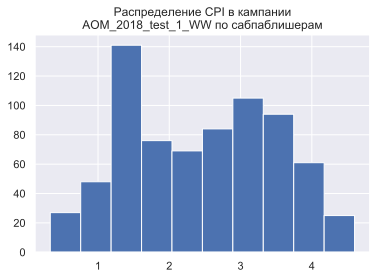

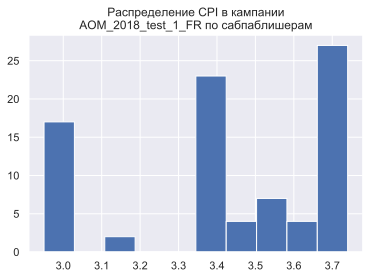

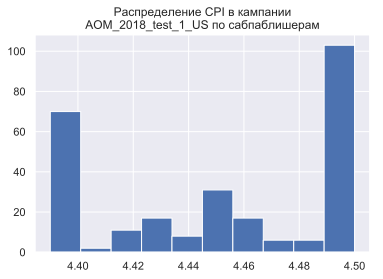

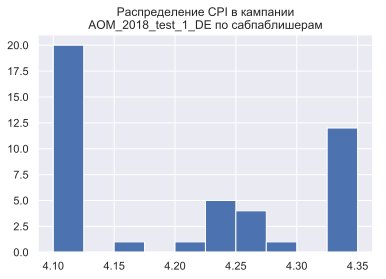

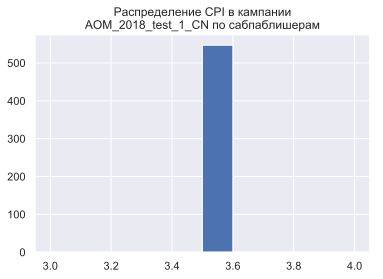

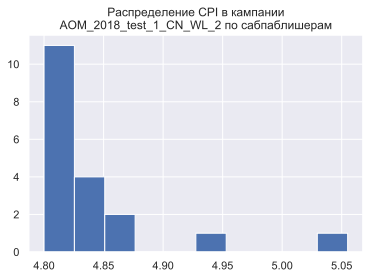

In [552]:
for campaign in installs.Campaign.unique():
    plt.figure()
    plt.title(f"Распределение CPI в кампании\n{campaign} по сабпаблишерам")
    cpi.loc[campaign].hist();

Только в кампании `AOM_2018_test_1_WW` распределение более-менее похоже на нормальное. Самый странный случай — кампания `AOM_2018_test_1_CN`, в которой все сабпаблишеры имеют одинаковый CPI. Спишем такие аномалии на особенности выборки для задания — кажется, она была не случайной.

Из-за таких аномалий стратегию ставок для каждой кампании стоит считать отдельно. В кампании `AOM_2018_test_1_WW` я бы отключил сабпаблишеров, которые находятся в нижнем дециле и повысил ставки у сабпаблишеров из верхнего дециля.

In [553]:
first_decile = cpi.loc["AOM_2018_test_1_WW"].quantile(.10)
last_decile = cpi.loc["AOM_2018_test_1_WW"].quantile(.90)
print(f"Исключаем, если CPI ниже {first_decile}, повышаем ставки, если CPI выше {last_decile}")

Исключаем, если CPI ниже 1.1738205128205128, повышаем ставки, если CPI выше 3.9


In [554]:
raise_rates_WW = cpi.loc["AOM_2018_test_1_WW"][cpi.loc["AOM_2018_test_1_WW"] > last_decile]
exclude_WW = cpi.loc["AOM_2018_test_1_WW"][cpi.loc["AOM_2018_test_1_WW"] < first_decile]

# сохраним список сабпаблишеров, которых следует исключить и которым надо повысить ставки
raise_rates_WW.to_excel("output/raise_rates_WW.xlsx")
exclude_WW.to_excel("output/exclude_WW.xlsx")

В остальных кампаниях разброс значений CPI для разных сабпаблишеров не сильно велик (например, в кампании `AOM_2018_test_1_US` разница между паблешерами с самым низким и самым высоким CPI составляет одну десятую, а в `AOM_2018_test_1_CN` вообще у всех CPI одинаков), поэтому я бы не стал выносить решение об исключении или повышении ставок до тех пор, пока в моём распоряжении не будет полная выборка.

## Проверить гипотезы: iPhone платит лучше iPad; iPhone X самый платящий девайс

Самый простой способ способ проверить эти гипотезы — построить графики. Зачастую, всё будет понятно из них.

### iPhone платит лучше iPad

Начнём с первой гипотезы и для начала построим круговые диаграммы, отражающие количество девайсов каждого вида и средний платёж их владельцев.

In [539]:
def iphone_ipad(device: str):
    for apple_device in ["iphone", "ipad"]:
        if apple_device in device.lower():
            return apple_device

payments["iphone_ipad"] = payments["Device Type"].apply(iphone_ipad)

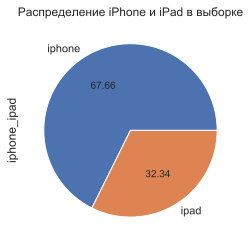

In [540]:
plt.title("Распределение iPhone и iPad в выборке")
payments["iphone_ipad"].value_counts().plot(kind="pie", autopct='%.2f');

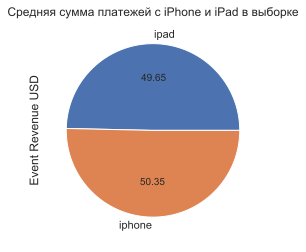

In [383]:
plt.title("Средняя сумма платежей с iPhone и iPad в выборке")

payments[["iphone_ipad", "Event Revenue USD"]] \
    .groupby("iphone_ipad").mean()["Event Revenue USD"].plot(kind="pie", autopct='%.2f');

Видим, что средняя сумма платежей весьма близка. Простой графический анализ в этом случае не поможет ответить на вопрос, а вот t-test поможет. t-test — это тест, который проверяет гипотезу о равенстве средних в двух выборках. В нашем случае это будут средние платежи владельцев iPhone и iPad. Но как и любой статистический тест, он имеет некоторые ограничения — распределение в выборках должно быть нормальным, и их дисперсии не должны сильно отличаться.

In [394]:
iphone_revenue = payments.query("iphone_ipad == 'iphone'")["Event Revenue USD"]
ipad_revenue = payments.query("iphone_ipad == 'ipad'")["Event Revenue USD"]

Проверим, сильно ли различаются дисперсии:

In [395]:
iphone_revenue.var(), ipad_revenue.var()

(318.4126246777497, 326.6367213821259)

Даже на глаз видно, что не сильно. Тогда посмотрим на распределение:

(<matplotlib.axes._subplots.AxesSubplot at 0x12cc4bac8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12cc4bac8>)

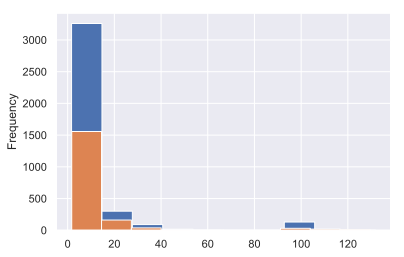

In [401]:
iphone_revenue.plot(kind="hist"), ipad_revenue.plot(kind="hist")

Распределение явно не нормальное — следствие всё той же неплоной выборки. Попробуем логарифмировать, а если не поможет — применим трансформацию Бокса-Кокса.

(<matplotlib.axes._subplots.AxesSubplot at 0x12c08d080>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12c08d080>)

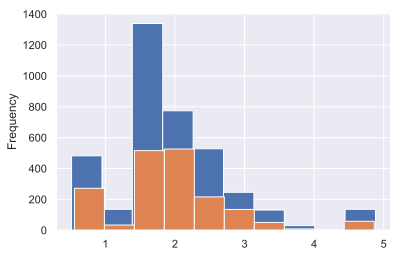

In [403]:
np.log(iphone_revenue).plot(kind="hist"), np.log(ipad_revenue).plot(kind="hist")

Да, логарифмирование сделало распределение более-менее нормальным. По крайнем мере, вряд ли на такой выборке удатся добиться чего-то сильно лучшего.

Время применять t-test:

In [404]:
from scipy.stats import ttest_ind

ttest_ind(iphone_revenue, ipad_revenue)

Ttest_indResult(statistic=0.30342072693291366, pvalue=0.7615804833690807)

p-value показывает вероятность того, что нулевая гипотеза о равенстве средних верна. В нашем случае p-value намного больше 0.05, поэтому мы не можем утверждать, что средние цены не равны. Следовательно **ответ: различие в платежах с iPhone и iPad статистически не значимо, нельзя сказать, что iPhone платит лучше iPad**.

### iPhone X самый платящий девайс
Начнём с перейдём ко второй гипотезе. Посмотрим на распределение среднего количество платежей по девайсу:

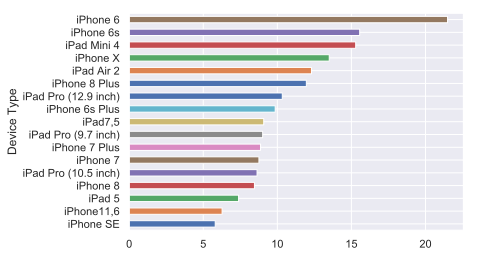

In [380]:
payments.groupby("Device Type")["Event Revenue USD"].mean().sort_values(ascending=True).plot.barh();

Весьма странная картина — с чего бы владельцам уже сильно устаревшего iPhone 6 быть самыми платежеспособными? Возможно, распределение количества устройств поможет дать ответ.

In [378]:
payments["Device Type"].value_counts(ascending=True)

iPhone 6                   1
iPhone SE                  2
iPhone11,6                 2
iPad7,5                   48
iPad Pro (9.7 inch)      121
iPhone 8                 160
iPhone 6s Plus           207
iPad 5                   231
iPad Pro (10.5 inch)     269
iPhone 6s                282
iPad Pro (12.9 inch)     283
iPad Mini 4              289
iPhone 8 Plus            482
iPad Air 2               577
iPhone 7                 637
iPhone 7 Plus            898
iPhone X                1133
Name: Device Type, dtype: int64

Теперь всё ясно — дело в очень перекошеной выборке. **В наборе данных имеется всего один человек с iPhone 6, и да — он платит больше, чем владельцы остальных устройств в среднем. Однако, на такой выборке нельзя делать статистически значимых выводов, на ней невозможно оценить ошибку. Для корректного ответа на поставленный вопрос я бы попросил полную выборку данных.**

# Сеть из слов с meduza.io

In [96]:
import requests
import pandas as pd
import networkx as nx
from pyquery import PyQuery as pq
import matplotlib.pyplot as plt
from pymystem3 import Mystem
import re
from collections import Counter

%config InlineBackend.figure_format = 'svg'

In [25]:
meduza_api_url = "https://meduza.io/api/w4/search?chrono=articles&page={page}&per_page=24&locale=ru"

pages_uls = []

for page in range(20):
    res = requests.get(meduza_api_url.format(page=page)).json()["collection"]
    pages_uls.extend(res)

In [27]:
pages_uls[:2]

['feature/2019/02/17/robert-gelbreyt-to-est-dzhoan-rouling-predstavlyaet-novoe-delo-kormorana-strayka',
 'feature/2019/02/16/laboratoriyu-openai-sozdali-dlya-razvitiya-iskusstvennogo-intellekta-na-blago-lyudey-u-uchenyh-poluchilsya-otlichnyy-generator-feykovyh-novostey']

In [38]:
all_text = []

for page_url in pages_uls[:2]:
    html = requests.get("https://meduza.io/" + page_url).text
    title = pq(html).find(".GeneralMaterial-container .RichTitle-root").text()
    body = pq(html).find(".GeneralMaterial-container .GeneralMaterial-body").text()
    all_text.append((title + " " + body).replace("\xa0", " ").replace("\n", " "))

In [97]:
m = Mystem()

def preprocess(text):
    text = re.sub("\W+", " ", all_text[0])
    lemmas = m.lemmatize(text)
    return " ".join(lemmas)

In [112]:
all_text_preprocessed = list(map(preprocess, all_text))

c_words = Counter([word for text in all_text_preprocessed for word in text.split()])
c_words.most_common(20)

[('в', 192),
 ('и', 170),
 ('он', 166),
 ('не', 152),
 ('страйк', 128),
 ('на', 110),
 ('с', 102),
 ('что', 86),
 ('она', 66),
 ('который', 56),
 ('его', 52),
 ('то', 50),
 ('быть', 50),
 ('робин', 48),
 ('у', 46),
 ('а', 44),
 ('барклай', 44),
 ('но', 40),
 ('свой', 40),
 ('как', 38)]

In [113]:
stopwords = [word for word, count in c_words.most_common() if count > 20 or count < 1]

In [114]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


cv = CountVectorizer(ngram_range=(1,2), max_features=50, stop_words=stopwords)
X = cv.fit_transform(all_text_preprocessed)
Xc = (X.T * X)
Xc.setdiag(0)

names = cv.get_feature_names()
df = pd.DataFrame(data = Xc.toarray(), columns = names, index = names)
df.head()

,барклый,без,бы,взять,военный,глаз,год,голос,да,даже,...,становиться,страек,сыщик,такой,там,тот,уже,хотя,чтобы,этот
барклый,0,160,112,80,80,112,160,80,80,128,...,144,96,96,80,80,128,96,112,128,144
без,160,0,140,100,100,140,200,100,100,160,...,180,120,120,100,100,160,120,140,160,180
бы,112,140,0,70,70,98,140,70,70,112,...,126,84,84,70,70,112,84,98,112,126
взять,80,100,70,0,50,70,100,50,50,80,...,90,60,60,50,50,80,60,70,80,90
военный,80,100,70,50,0,70,100,50,50,80,...,90,60,60,50,50,80,60,70,80,90


In [117]:
G = nx.convert_matrix.from_pandas_adjacency(df)

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


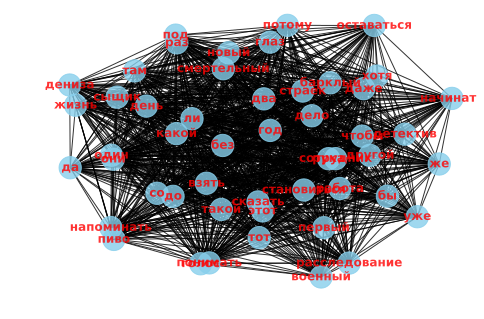

In [118]:
nx.draw(G, with_labels=True, node_color="skyblue", alpha=0.8, node_size=500, font_color="#ff0000", font_weight='bold')
plt.show();

# Прогнозирование цен на яблоки

Сезонность — это некоторый повторяющийся паттерн, наблюдаемый во временных рядах. Например, количество автопроишествий каждый год увеличивается с наступлением зимы, как и количество аварий в сфере ЖКХ; цены на овощи снижаются летом и возрастаю зимов, когда буквально «не сезон», а количество обращений в шиномонтаж увеличивается весной и осенью и [т.д.](https://habr.com/ru/company/2gis/blog/414041/) Выявить сезонность проще всего при помощи функции автокорреляции — в аналогичные периоды других сезонов коррелелограмма будет показывать заметно более высокие значения автокорреляции.

Сезонные колебания надо постараться учесть в модели, иначе её предсказания будут действовать только до конца сезона. Если разные способы это сделать. Можно трансформировать данные ([seasonal adjustment](https://en.wikipedia.org/wiki/Seasonal_adjustment)) или использовать специально предназначенные для этого модели — SARIMA.

Возьмем в качестве примера временной ряд, где вполне возможно ожидать сезонность — цену на килограмм яблок в России — определим, действительно в нём имеется сезонный компонент, а затем построим прогноз при помощи модели SARIMA. Цену на яблоки и другие товары можно узнать га [сайте РосСтата](http://www.gks.ru/wps/wcm/connect/rosstat_main/rosstat/ru/statistics/tariffs/).

In [617]:
apples = pd.read_csv("http://nagornyy.me/datasets/apples_gks.csv", sep=";", encoding="cp1251", header=1)
apples.head()

,Unnamed: 0,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 10
0,01 неделя (на 11 января),"65,77",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,02 неделя (на 17 января),"66,54",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,03 неделя (на 24 января),"67,59",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,04 неделя (на 31 января),"68,21",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,05 неделя (на 7 февраля),"69,01",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Подготовим данные и построим график:

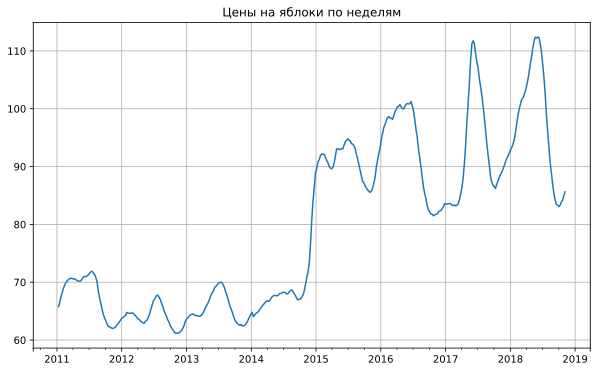

In [872]:
dateindex = pd.date_range(start='01-10-2011', periods=len(apples), freq='7D')
apples.index = dateindex
season = pd.Series(index=dateindex)

for year in range(2011, 2019):
    season = season.fillna(pd.to_numeric(apples[str(year)].str.replace(",", ".")))
    
season.plot(title="Цены на яблоки по неделям", grid=True);

Построим короллелограмму и посмотрим, есть ли периоды, когда кореляция намного выше. Поскольку сезон длится 3 месяца, укрупним данные.

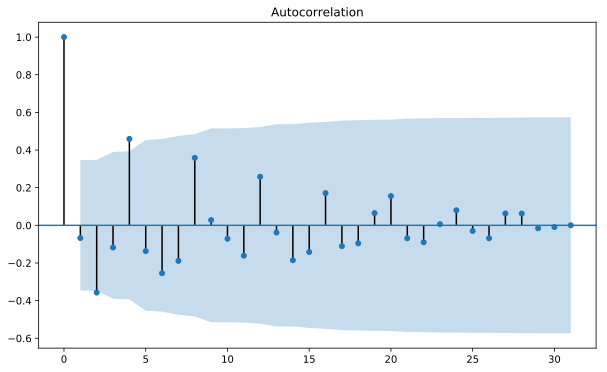

In [874]:
plot_acf(season.resample("3M").last().diff().dropna());

Определённо сезонность присутвует — мы наблюдаем корреляция с лагом каждые четыре шага.

Можно легко её устранить, продифференцировав временной ряд вручную.

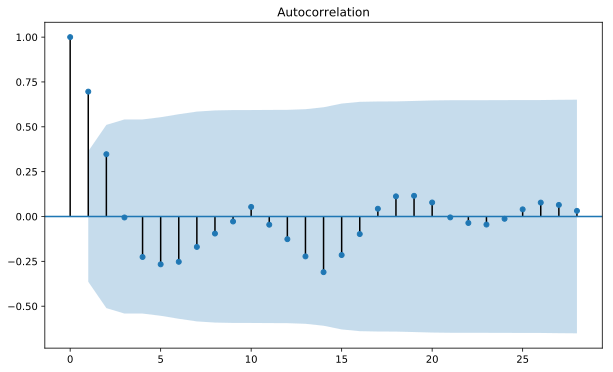

In [681]:
plot_acf(season.resample("3M").last().diff(4).dropna());

Определить наличие сезонности можно также при помощи функции `seasonal_decompose` пакета *statsmodels*, которая разложит временной ряд на три компонента — трендовый, сезонный и всё остальное по [оригинальному методу](https://otexts.com/fpp2/classical-decomposition.html) 1920-х годов (https://www.zotero.org/ihun/items/itemKey/UA52GKRF).

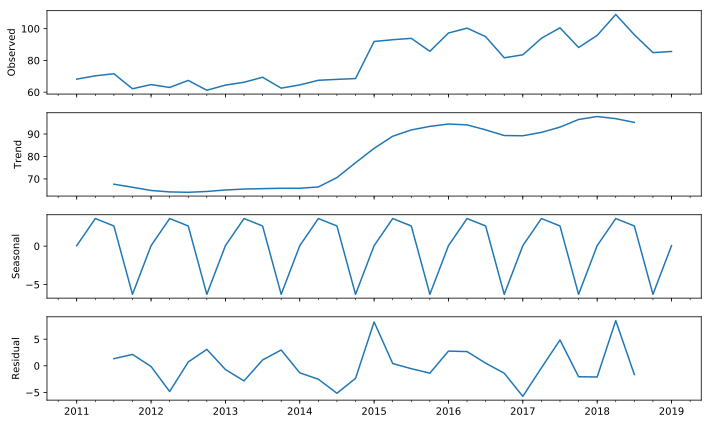

In [685]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(season.resample("3M").last(), model='additive')
result.plot();

### SARIMA

Для построения авторегрессионной модели на временных рядах с присутствием сезонного компонента используется расширение очередное расширение модели ARIMA — SARIMA, где S означает seasonal. В общем виде модель выглядит так:
$$ARIMA(p,d,q)(P,D,Q)_s,$$
где $p, d, q$ — старые параметры пришедщие из ARIMA, а (P,D,Q)<sub>s</sub> — группа новых параметров, специфичных для SARIMA. Они задают, насколько сезонов мы смотрим назад, когда её предсказываем. Рассмотрим каждый параметр подробнее. 

* $p$ - порядок модели $AR(p)$;
* $d$ - порядок интегрирования;
* $q$ - порядок модели $MA(q)$
* $P$ - порядок сезонной составляющей $SAR(P)$;
* $D$ - порядок интегрирования сезонной составляющей;
* $Q$ - порядок сезонной составляющей $SMA(Q)$;
* $s$ — размерность сезонности.

Имплементация этой модели также есть в библиотеке statsmodels (https://www.zotero.org/ihun/items/itemKey/TSTSVYYS), так что ей и воспользуемся.

In [726]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (1, 1, 1)
seasonal_order = (1, 1, 1, 4)
model = SARIMAX(season.resample("3M").last(), order=order, seasonal_order=seasonal_order)
res = model.fit()

In [727]:
df = pd.DataFrame()
df['past'] = season.resample("3M").last().append(res.forecast(10))
df['future'] = res.forecast(10)

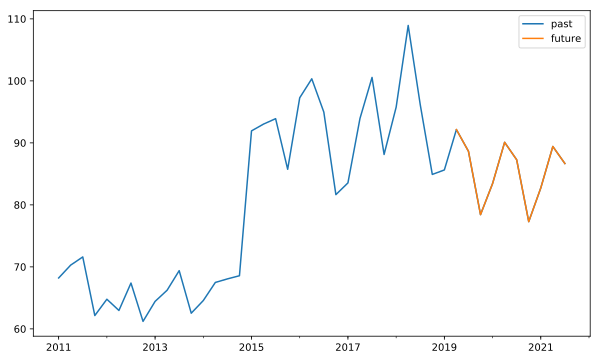

In [728]:
df.plot();